In [1]:
!unzip /content/SDN_Intrusion.csv.zip

Archive:  /content/SDN_Intrusion.csv.zip
  inflating: SDN_Intrusion.csv       


In [2]:
# Import all required libraries

# Data Loading and precessing
import pandas as pd
import numpy as np

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay

# Machine learning model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Handle warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load data
df = pd.read_csv("/content/SDN_Intrusion.csv")

In [4]:
# View Dataset
df.head()

,Unnamed: 0,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Class
0,0,80,9865922,5,0,30,0,6,6,6.000000,...,20,1986.00000,0.0000,1986,1986,9.863936e+06,0.00000,9863936,9863936,DDoS
1,1,443,158423,24,22,703,24564,453,0,29.291667,...,32,0.00000,0.0000,0,0,0.000000e+00,0.00000,0,0,BENIGN
2,2,443,61163904,14,12,993,3445,620,0,70.928571,...,20,147216.66670,152989.5108,459505,84515,1.000000e+07,21747.04690,10100000,9999779,BENIGN
3,3,443,110544045,18,18,1213,4216,812,0,67.388889,...,20,75305.72727,133115.4997,476664,35046,9.970950e+06,80601.91884,10000000,9728297,BENIGN
4,4,53,185,2,2,104,136,52,52,52.000000,...,20,0.00000,0.0000,0,0,0.000000e+00,0.00000,0,0,BENIGN


In [5]:
# Data Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188333 entries, 0 to 1188332
Data columns (total 80 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   Unnamed: 0                    1188333 non-null  int64  
 1    Destination Port             1188333 non-null  int64  
 2    Flow Duration                1188333 non-null  int64  
 3    Total Fwd Packets            1188333 non-null  int64  
 4    Total Backward Packets       1188333 non-null  int64  
 5   Total Length of Fwd Packets   1188333 non-null  int64  
 6    Total Length of Bwd Packets  1188333 non-null  int64  
 7    Fwd Packet Length Max        1188333 non-null  int64  
 8    Fwd Packet Length Min        1188333 non-null  int64  
 9    Fwd Packet Length Mean       1188333 non-null  float64
 10   Fwd Packet Length Std        1188333 non-null  float64
 11  Bwd Packet Length Max         1188333 non-null  int64  
 12   Bwd Packet Length Min      

In [6]:
# Check for NULL values in the dataset
df.isna().sum().sum()

np.int64(71)

In [7]:
# Clean column names
df.columns = df.columns.str.strip()

In [8]:
# Drop index column
df.drop(columns=['Unnamed: 0'], inplace=True)

In [9]:
# Fill NULL values
df['Flow Bytes/s'].fillna(df['Flow Bytes/s'].median(), inplace=True)

In [10]:
# Encode target column
label_encoder = LabelEncoder()
df['Class'] = label_encoder.fit_transform(df['Class'])

In [11]:
# Remap classes to handle imbalance
df['Class'] = df['Class'].replace({1: 1, 2: 1, 3: 1, 4: 1}) # Map all attacks (1-4) to 1 (Malicious)

### Data Visualisation

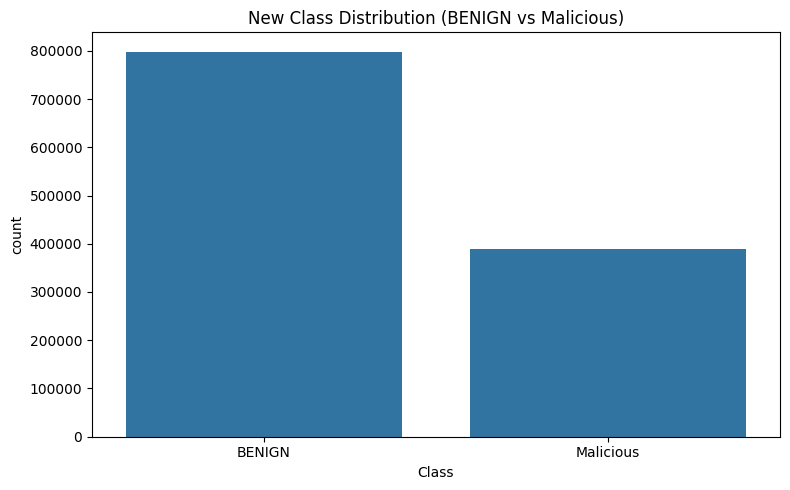

In [12]:
# Display new class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Class', data=df)
plt.xticks(ticks=[0, 1], labels=['BENIGN', 'Malicious'])
plt.title("New Class Distribution (BENIGN vs Malicious)")
plt.tight_layout()
plt.show()

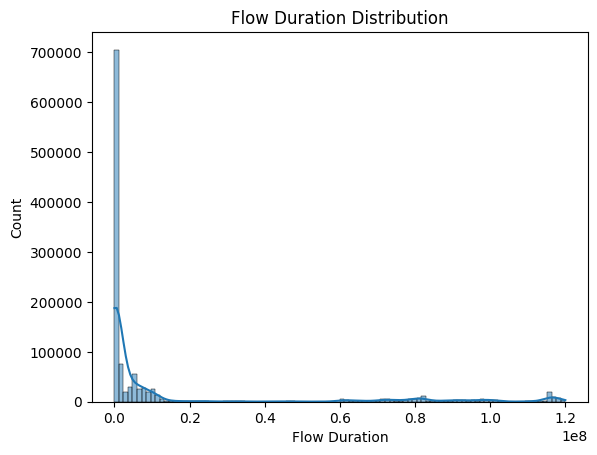

In [13]:
# Histogram of Flow Duration
sns.histplot(df['Flow Duration'], bins=100, kde=True)
plt.title("Flow Duration Distribution")
plt.show()

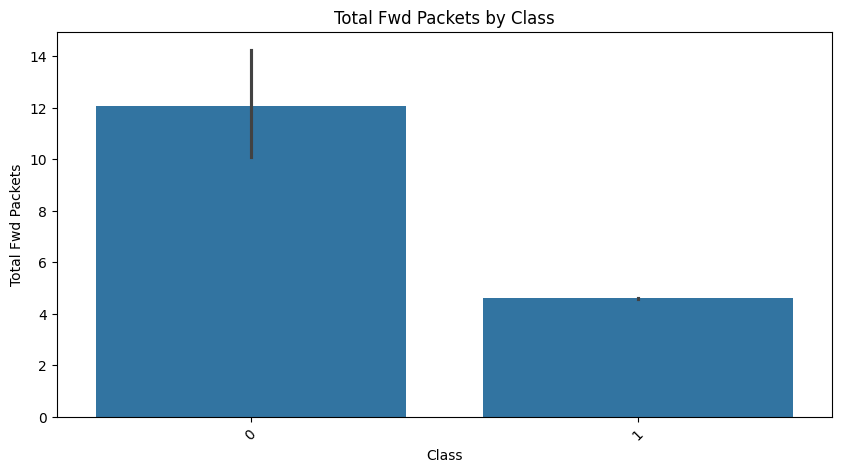

In [14]:
# Barplot of Total Fwd Packets
plt.figure(figsize=(10, 5))
sns.barplot(x='Class', y='Total Fwd Packets', data=df)
plt.xticks(rotation=45)
plt.title("Total Fwd Packets by Class")
plt.show()

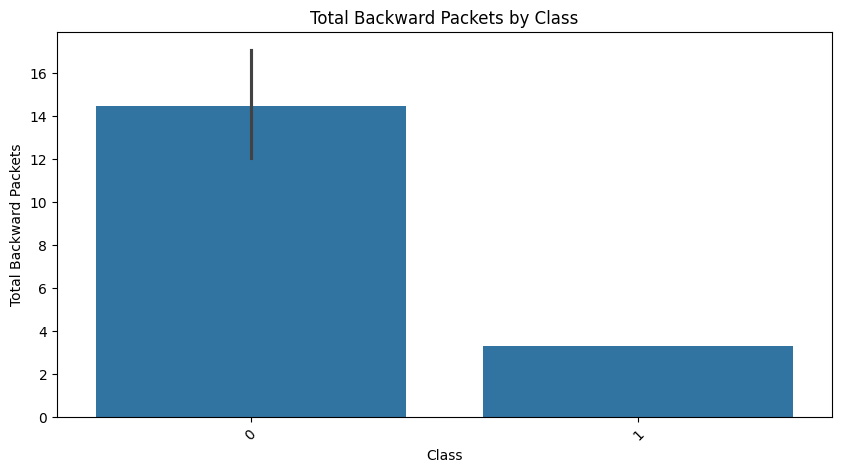

In [15]:
# Barplot of Total Backward Packets
plt.figure(figsize=(10, 5))
sns.barplot(x='Class', y='Total Backward Packets', data=df)
plt.xticks(rotation=45)
plt.title("Total Backward Packets by Class")
plt.show()

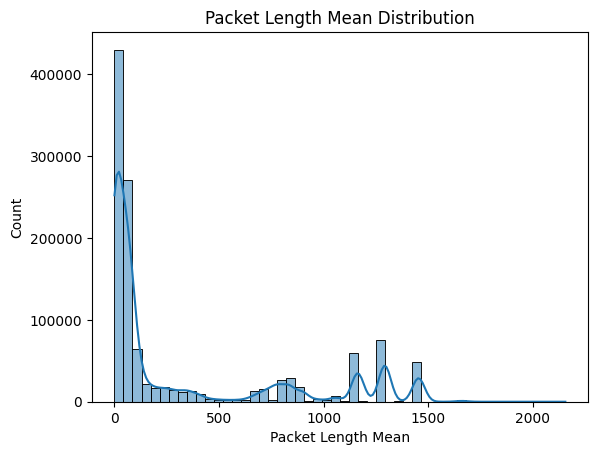

In [16]:
# Distribution of Packet Length Mean
sns.histplot(df['Packet Length Mean'], bins=50, kde=True)
plt.title("Packet Length Mean Distribution")
plt.show()

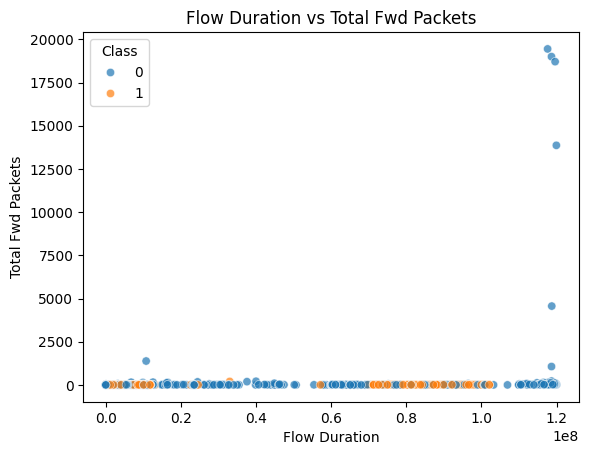

In [17]:
# Scatter plot
sample_df = df.sample(5000, random_state=42)
sns.scatterplot(x='Flow Duration', y='Total Fwd Packets', hue='Class', data=sample_df, palette='tab10', alpha=0.7)
plt.title("Flow Duration vs Total Fwd Packets")
plt.show()

### Feature Engineering

In [18]:
# Split Target and feature column
X = df.drop(columns=['Class'])
y = df['Class']

In [19]:
# Check for infinite values
print("Number of infinite values before handling:", np.isinf(X).sum().sum())

# Replace infinite values with the median of each column
X.replace([np.inf, -np.inf], np.nan, inplace=True)
for col in X.columns:
    X[col].fillna(X[col].median(), inplace=True)

print("Number of infinite values after handling:", np.isinf(X).sum().sum())

Number of infinite values before handling: 1031
Number of infinite values after handling: 0


In [20]:
# Apply Scalling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [21]:
# Split training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

### TRAIN MODELS

* Model 1

In [22]:
# 1. Logistic Regression
log_model = LogisticRegression(max_iter=200)

In [23]:
# Fit training data to model
log_model.fit(X_train, y_train)

LogisticRegression(max_iter=200)

In [24]:
# Test Model
y_pred = log_model.predict(X_test)

In [25]:
# Model Evaluation
acc_log = accuracy_score(y_test, y_pred)
f1_log = f1_score(y_test, y_pred)
prec_log = precision_score(y_test, y_pred)
rec_log = recall_score(y_test, y_pred)

print("Accuracy:", acc_log)
print("F1 Score:", f1_log)
print("Precision:", prec_log)
print("Recall:", rec_log)

Accuracy: 0.988799454699222
F1 Score: 0.9829223228720265
Precision: 0.9837301281557388
Recall: 0.9821158431835081


In [26]:
# Classification Model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    159665
           1       0.98      0.98      0.98     78002

    accuracy                           0.99    237667
   macro avg       0.99      0.99      0.99    237667
weighted avg       0.99      0.99      0.99    237667



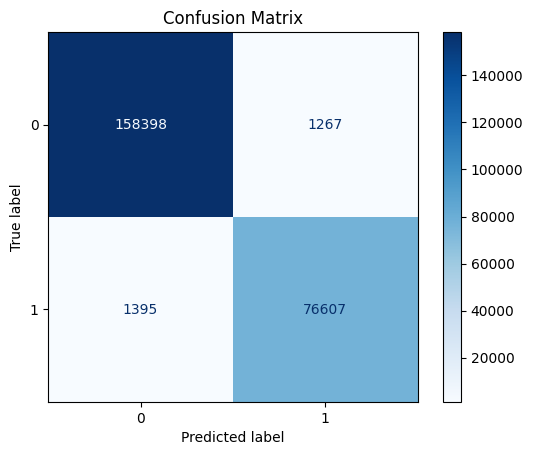

In [27]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

* Model 2

In [28]:
# 2. Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)

In [29]:
# Train Model
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [30]:
# Test Model
y_pred = dt_model.predict(X_test)

In [31]:
# Model Evaluation
acc_dt = accuracy_score(y_test, y_pred)
f1_dt = f1_score(y_test, y_pred)
prec_dt = precision_score(y_test, y_pred)
rec_dt = recall_score(y_test, y_pred)

print("Accuracy:", acc_dt)
print("F1 Score:", f1_dt)
print("Precision:", prec_dt)
print("Recall:", rec_dt)

Accuracy: 0.9999747545936121
F1 Score: 0.9999615394477065
Precision: 0.9999615394477065
Recall: 0.9999615394477065


In [32]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    159665
           1       1.00      1.00      1.00     78002

    accuracy                           1.00    237667
   macro avg       1.00      1.00      1.00    237667
weighted avg       1.00      1.00      1.00    237667



<function matplotlib.pyplot.show(close=None, block=None)>

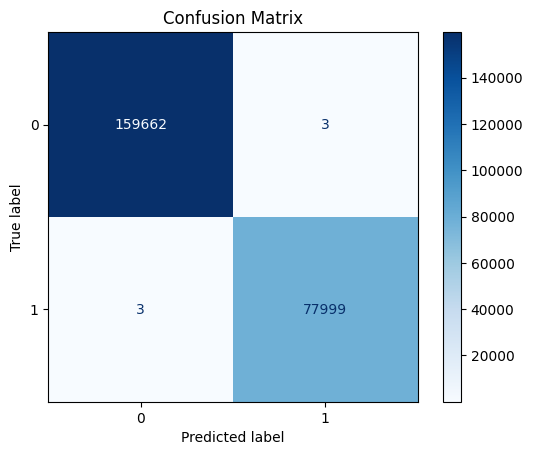

In [33]:
# Plot Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show

* Model 3

In [34]:
# 3. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [35]:
# Train Model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [36]:
# Model Testing
y_pred = rf_model.predict(X_test)

In [37]:
# Model Evaluation
acc_rf = accuracy_score(y_test, y_pred)
f1_rf = f1_score(y_test, y_pred)
prec_rf = precision_score(y_test, y_pred)
rec_rf = recall_score(y_test, y_pred)

print("Accuracy:", acc_rf)
print("F1 Score:", f1_rf)
print("Precision:", prec_rf)
print("Recall:", rec_rf)

Accuracy: 0.9999789621613434
F1 Score: 0.9999679485124905
Precision: 1.0
Recall: 0.9999358990795107


In [38]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    159665
           1       1.00      1.00      1.00     78002

    accuracy                           1.00    237667
   macro avg       1.00      1.00      1.00    237667
weighted avg       1.00      1.00      1.00    237667



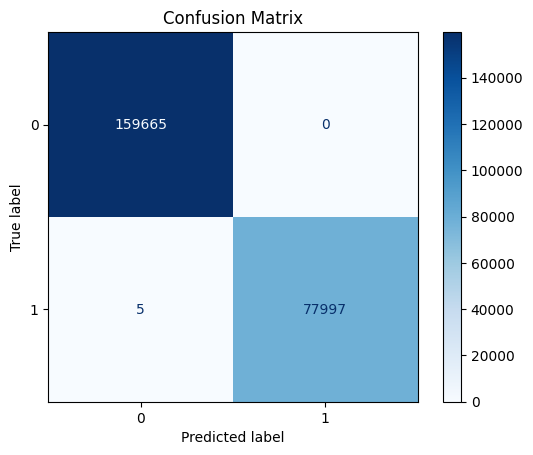

In [39]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

* Model 4

In [40]:
# 4. XGBoost
xgb_model = XGBClassifier(random_state=42)

In [41]:
# Model Training
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [42]:
# Test Model
y_pred = xgb_model.predict(X_test)

In [43]:
# Model Evaluation
acc_xgb = accuracy_score(y_test, y_pred)
f1_xgb = f1_score(y_test, y_pred)
prec_xgb = precision_score(y_test, y_pred)
rec_xgb = recall_score(y_test, y_pred)

print("Accuracy:", acc_xgb)
print("F1 Score:", f1_xgb)
print("Precision:", prec_xgb)
print("Recall:", rec_xgb)

Accuracy: 0.9999957924322687
F1 Score: 0.9999935898668615
Precision: 1.0
Recall: 0.9999871798159021


In [44]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    159665
           1       1.00      1.00      1.00     78002

    accuracy                           1.00    237667
   macro avg       1.00      1.00      1.00    237667
weighted avg       1.00      1.00      1.00    237667



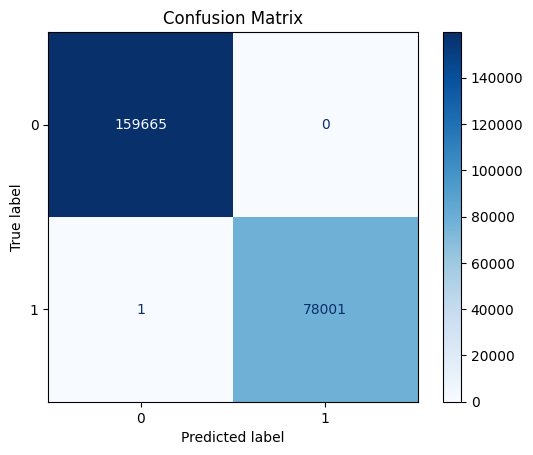

In [45]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

* Model 5

In [46]:
# 5. MLP Classifier
mlp_model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=100, random_state=42)

In [47]:
# Train Model
mlp_model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=100, random_state=42)

In [48]:
# Test Model
y_pred = mlp_model.predict(X_test)

In [49]:
# Model Evaluation
acc_mlp = accuracy_score(y_test, y_pred)
f1_mlp = f1_score(y_test, y_pred)
prec_mlp = precision_score(y_test, y_pred)
rec_mlp = recall_score(y_test, y_pred)

print("Accuracy:", acc_mlp)
print("F1 Score:", f1_mlp)
print("Precision:", prec_mlp)
print("Recall:", rec_mlp)

Accuracy: 0.9986199177841265
F1 Score: 0.9979009612061793
Precision: 0.9962560695118835
Recall: 0.9995512935565755


In [50]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    159665
           1       1.00      1.00      1.00     78002

    accuracy                           1.00    237667
   macro avg       1.00      1.00      1.00    237667
weighted avg       1.00      1.00      1.00    237667



<function matplotlib.pyplot.show(close=None, block=None)>

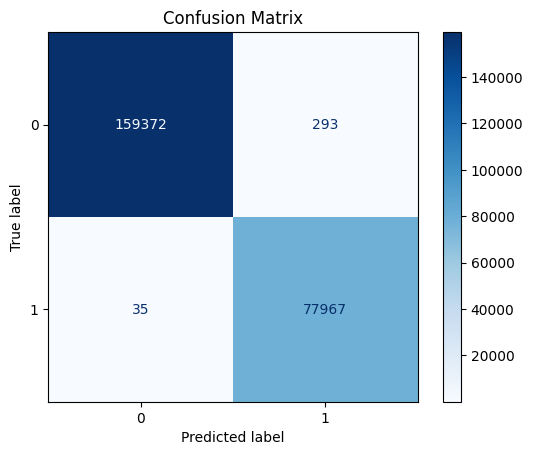

In [51]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show

In [52]:
# Create a DataFrame to compare model metrics
metrics_data = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'MLP Classifier'],
    'Accuracy': [acc_log, acc_dt, acc_rf, acc_xgb, acc_mlp],
    'F1 Score': [f1_log, f1_dt, f1_rf, f1_xgb, f1_mlp],
    'Precision': [prec_log, prec_dt, prec_rf, prec_xgb, prec_mlp],
    'Recall': [rec_log, rec_dt, rec_rf, rec_xgb, rec_mlp]
}

metrics_df = pd.DataFrame(metrics_data)

# Display the comparison table
print("\nModel Comparison:")
display(metrics_df)


Model Comparison:


,Model,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression,0.988799,0.982922,0.983730,0.982116
1,Decision Tree,0.999975,0.999962,0.999962,0.999962
2,Random Forest,0.999979,0.999968,1.000000,0.999936
3,XGBoost,0.999996,0.999994,1.000000,0.999987
4,MLP Classifier,0.998620,0.997901,0.996256,0.999551


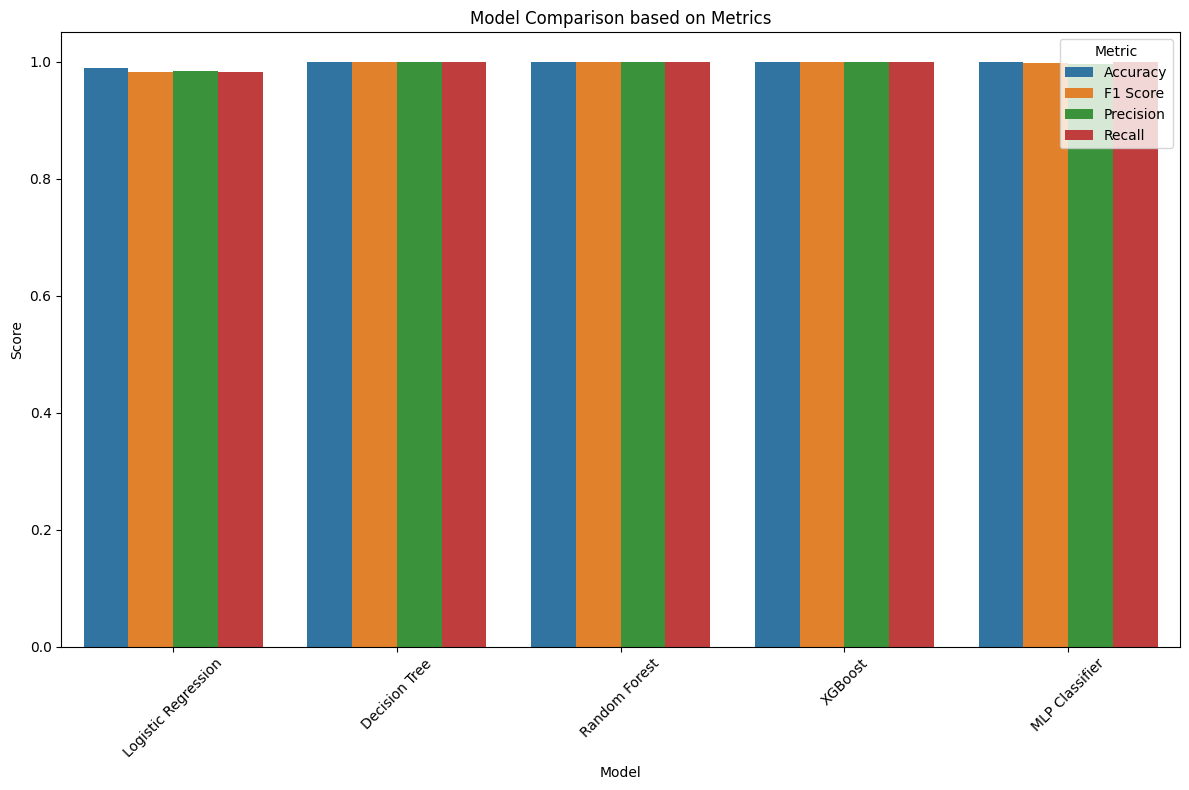

In [53]:
# Plotting the comparison
metrics_df_melted = metrics_df.melt('Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_df_melted)
plt.title("Model Comparison based on Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

In [54]:
# Select 20 random indices from the test set
random_indices = np.random.choice(len(X_test), 20, replace=False)

# Get the actual and predicted values for the random indices
actual_values = y_test.iloc[random_indices]
predicted_values = xgb_model.predict(X_test[random_indices])

# Create a DataFrame to display the results
prediction_comparison = pd.DataFrame({'Actual': actual_values, 'Predicted': predicted_values})

# Display the comparison
print("\nActual vs Predicted values for 20 random samples:")
display(prediction_comparison)


Actual vs Predicted values for 20 random samples:


,Actual,Predicted
1126339,0,0
561767,0,0
494285,0,0
744634,0,0
814383,1,1
715286,1,1
166763,0,0
797619,0,0
662805,0,0
1188110,1,1
